total accuracy of Client 1 : 100.0
total accuracy of Client 2 : 100.0
total accuracy of Client 3 : 90.0


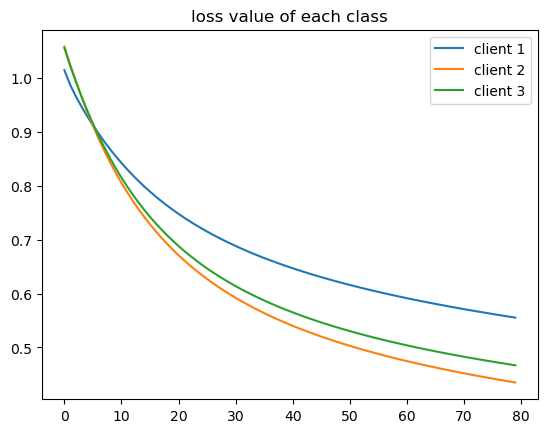

In [42]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

class FedLearning_MLR(object):
    
    #Loading iris data and shuffling for spliting data to clients
    def __init__(self, obj_data):
        self.data = obj_data        
        df = pd.DataFrame(data = self.data.data, columns = self.data.feature_names)
        df['target'] = self.data.target
        df = shuffle(df)
        self.x_data = df.iloc[:, :-1]
        self.y_data = df.iloc[:, [-1]]
    
    #Spliting data by the number of clients / spliting training(80%) and test data(20%) of each client
    def client_data_partition(self, num):
        client = [];client_ans = [];client_test =[];client_ans_test=[]
        split_loc = len(self.x_data)//num
        for i in range(num):
            temp_x = self.x_data.iloc[split_loc*i:split_loc*(i+1), :]
            temp_y = self.y_data.iloc[split_loc*i:split_loc*(i+1), :]
            client.append(temp_x.iloc[:int(len(temp_x)*0.8), :])
            client_ans.append(temp_y.iloc[:int(len(temp_y)*0.8), :])
            client_test.append(temp_x.iloc[int(len(temp_x)*0.8):, :])
            client_ans_test.append(temp_y.iloc[int(len(temp_y)*0.8):, :])
        return client, client_ans, client_test, client_ans_test
    
    #initialize weight of model
    def weight_ini(self):
        #.shape[1] is the number of columns
        #.shape[0] is the number of rows
        n_features = self.x_data.shape[1]
        w = np.zeros((3,n_features)).T * 0.1
        b = np.ones((3,1))                 
        return w, b
    
    #Average weights and bias learned using client data
    def server_aggre(self, client_weight):
        weight = np.zeros((client_weight[0].shape[0],client_weight[0].shape[1]))
        for i in range(len(client_weight)):
            weight += client_weight[i]
        Avg_weight = weight/len(client_weight)
        #Avg_bias = np.mean(client_bias)
        return Avg_weight
    
    def client(self, weight, bias, client, client_ans, iteration, learning_rate):
        #calculate client data w.r.t current weight and bias
        for i in range(iteration):
            result = np.matmul(client, weight) #+ bias
            
            #making probability using the above result
            prob_result = self.softmax(result)
            prob_result = pd.DataFrame.to_numpy(prob_result.T)
            
            #making target as numerical data using one hot encoding
            client_ans = pd.DataFrame.to_numpy(client_ans)
            target = self.one_hot_encoding(client_ans)
            
            #calculate loss value using cross entropy
            loss = self.cross_entropy(target, prob_result)
            
            #update weight and bias using gradient descent
            gradient = self.cost_gradient(target, prob_result, client)
            weight = weight - learning_rate * gradient
            
            prob_result = pd.DataFrame(prob_result)
            client_ans = pd.DataFrame(client_ans)
        
        return weight, loss
    
    #calculate accuracy of the model(Final process)
    def client_predict(self, weight, bias, client_test, client_ans_test):
        tot_setosa = 0; tot_versicolor = 0; tot_virginica = 0
        accu_setosa = 0; accu_versicolor = 0; accu_virginica = 0
        result_test = np.matmul(client_test, weight) #+ bias
        prob_result_test = self.softmax(result_test)
        prob_result_test = pd.DataFrame.to_numpy(prob_result_test.T)
        predict = np.argmax(prob_result_test, axis = 1)
        client_ans_test = pd.DataFrame.to_numpy(client_ans_test)
        
        for j in range(len(client_ans_test)):
            if((client_ans_test[j] == 0)):
                tot_setosa += 1
            elif((client_ans_test[j] == 1)):
                tot_versicolor += 1
            elif((client_ans_test[j] == 2)):
                tot_virginica += 1
  
        for i in range(len(predict)):
            if((predict[i] == client_ans_test[i]) and (client_ans_test[i] == 0)):
                accu_setosa += 1
            elif((predict[i] == client_ans_test[i]) and (client_ans_test[i] == 1)):
                accu_versicolor += 1
            elif((predict[i] == client_ans_test[i]) and (client_ans_test[i] == 2)):
                accu_virginica += 1
                
        total_accuracy = (accu_setosa+accu_versicolor+accu_virginica)/len(client_ans_test)*100
        setosa_accuracy = accu_setosa/tot_setosa*100
        versicolor_accuracy = accu_versicolor/tot_versicolor*100
        virginica_accuracy = accu_virginica/tot_virginica*100

        return total_accuracy, setosa_accuracy, versicolor_accuracy, virginica_accuracy
        
    #I use the multinomial LR model instead of binomial LR
    #becasuse the dataset has three classes(multi-class)
    #change loss func(log loss to cross-entropy loss)
    #and change the sigmoid func to softmax func
    def softmax(self, result):
        final_result = np.exp(result).T / np.sum(np.exp(result), axis = 1).T
        return final_result
    
    #One hot encoding converts the categorical data into a numerical form
    def one_hot_encoding(self, y_data):
        OneHotEncoding = []
        encoding = []
        for i in range(len(y_data)):
            if(y_data[i] == 0):
                encoding = np.array([1,0,0]) #class 1(setosa)
            elif(y_data[i] == 1):
                encoding = np.array([0,1,0]) #class 2(versicolor)
            elif(y_data[i] == 2):
                encoding = np.array([0,0,1]) #class 3(virginica)
            OneHotEncoding.append(encoding)
        return OneHotEncoding
    
    #use cross entropy for calculating loss value
    def cross_entropy(self, y_data, y_pred):
        loss = -np.sum(y_data * np.log(y_pred + 10**-100)) / len(y_data)
        return loss
    
    #use gradient descent for updating weight and bias
    def cost_gradient(self, y_data, y_pred, X):
        grad = -(np.dot(X.T, (y_data-y_pred))) / len(X)
        return grad
    
########################################################
#From this, the main code starts
########################################################
#upload iris data 
iris = load_iris()
FL = FedLearning_MLR(iris)

#data partitioning <- the number of client is three
(client, client_ans, client_test, client_ans_test) = FL.client_data_partition(3)
#training data in each client
client_1 = client[0].copy(); client_ans_1 = client_ans[0].copy()
client_2 = client[1].copy(); client_ans_2 = client_ans[1].copy()
client_3 = client[2].copy(); client_ans_3 = client_ans[2].copy()
#test data in each client
client_test_1 = client_test[0].copy(); client_ans_test_1 = client_ans_test[0].copy()
client_test_2 = client_test[1].copy(); client_ans_test_2 = client_ans_test[1].copy()
client_test_3 = client_test[2].copy(); client_ans_test_3 = client_ans_test[2].copy()

#initialize weight and bias in server part
(w,b) = FL.weight_ini()
communication = 80   #the number of communication between server and client
training_iter_1 = 10  #the number of training in client 1
training_iter_2 = 10  #the number of training in client 2
training_iter_3 = 10  #the number of training in client 3
learning_rate = 0.005   #learning rate in the process of training in client part

x = []; loss1 = []; loss2 = []; loss3 = []
for i in range(communication):
    #training in each client part using data of each client
    w1, loss_1 = FL.client(w, b, client_1, client_ans_1, training_iter_1, learning_rate)
    w2, loss_2 = FL.client(w, b, client_2, client_ans_2, training_iter_2, learning_rate)
    w3, loss_3 = FL.client(w, b, client_3, client_ans_3, training_iter_3, learning_rate)
    #weight average in server
    tot_weight = [w1, w2, w3]
    Avg_weight = FL.server_aggre(tot_weight)
    #send new weight to the each client
    w = Avg_weight.copy()
    x.append(i); loss1.append(loss_1); loss2.append(loss_2); loss3.append(loss_3)
    
#plot the loss value of each class
plt.title("loss value of each class")
plt.plot(x,loss1, label = 'client 1')
plt.plot(x,loss2, label = 'client 2')
plt.plot(x,loss3, label = 'client 3')    
plt.legend()

#Calculate the accuracy of each client using test data respectively
(total_accu_1, setosa_accu_1, versicolor_accu_1, virginica_accu_1) = FL.client_predict(w1, b, client_test_1, client_ans_test_1)
(total_accu_2, setosa_accu_2, versicolor_accu_2, virginica_accu_2) = FL.client_predict(w2, b, client_test_2, client_ans_test_2)
(total_accu_3, setosa_accu_3, versicolor_accu_3, virginica_accu_3) = FL.client_predict(w3, b, client_test_3, client_ans_test_3)
print("total accuracy of Client 1 :", total_accu_1)
print("total accuracy of Client 2 :", total_accu_2)
print("total accuracy of Client 3 :", total_accu_3)